In [66]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [68]:
!pip install kaggle
#upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"anikaaftab","key":"10d454f2f4607aa4984c4776d3d9f854"}'}

In [69]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#changing permission
!chmod 600 ~/.kaggle/kaggle.json


from zipfile import ZipFile
file_name='/content/gdrive/MyDrive/Soft Computing LAB/Dataset_2.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [70]:
PATH = '/content/'

In [71]:
data_train = pd.read_csv(PATH + 'Dataset_2/verification_train.csv')
data_test = pd.read_csv(PATH + 'Dataset_2/verification_test.csv')

In [72]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [73]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [74]:
X_data = data_train.drop("label", axis=1).values.astype(np.uint8)
y_data = data_train["label"].values

X_test = data_test.drop("label", axis=1).values.astype(np.uint8)
y_test = data_test["label"].values

In [75]:
class DigitsDataset(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = np.reshape(self.X[idx], (28, 28, 1))
        if self.transforms is not None:
            X = self.transforms(X)
        if self.y is not None:
            return X, self.y[idx]
        else:
            return X

In [76]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [77]:
train_data = DigitsDataset(X=X_data, y=y_data, transforms=transform_train)
test_data = DigitsDataset(X=X_test, y=y_test, transforms=transform_test)

# EXPERIMENT 1:
## Hyperparameters:
**Iteration: 20k**

**Batch Size: 20**

**Learning Rate: 0.01**

**Number of Hidden Layers: 6 (ReLU->ReLU->ReLU->ReLU->ReLU->ReLU)**

**Dimension of Hidden Layers: 200**

**Optimizer: Adam**


In [78]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6


In [79]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:3000
Test dataloader:500


In [80]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [81]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [83]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 1.3411246538162231. Accuracy: 56.31
Iteration: 1000. Loss: 1.0955101251602173. Accuracy: 65.65
Iteration: 1500. Loss: 1.6064727306365967. Accuracy: 50.51
Iteration: 2000. Loss: 1.7295204401016235. Accuracy: 36.66
Iteration: 2500. Loss: 0.9662997126579285. Accuracy: 62.61
Iteration: 3000. Loss: 0.630210280418396. Accuracy: 68.59
Epoch:  2
Iteration: 3500. Loss: 1.287900447845459. Accuracy: 67.41
Iteration: 4000. Loss: 0.6853191256523132. Accuracy: 72.91
Iteration: 4500. Loss: 0.885435938835144. Accuracy: 66.49
Iteration: 5000. Loss: 1.6095632314682007. Accuracy: 38.97
Iteration: 5500. Loss: 1.6079782247543335. Accuracy: 30.17
Iteration: 6000. Loss: 1.4788111448287964. Accuracy: 25.94
Epoch:  3
Iteration: 6500. Loss: 1.9709539413452148. Accuracy: 27.3
Iteration: 7000. Loss: 1.5495507717132568. Accuracy: 35.63
Iteration: 7500. Loss: 1.3448984622955322. Accuracy: 33.39
Iteration: 8000. Loss: 1.1400601863861084. Accuracy: 39.27
Iteration: 8500. Loss: 1.279553

[1.3411246538162231, 1.0955101251602173, 1.6064727306365967, 1.7295204401016235, 0.9662997126579285, 0.630210280418396, 1.287900447845459, 0.6853191256523132, 0.885435938835144, 1.6095632314682007, 1.6079782247543335, 1.4788111448287964, 1.9709539413452148, 1.5495507717132568, 1.3448984622955322, 1.1400601863861084, 1.2795536518096924, 1.2573952674865723, 1.6461836099624634, 1.0052810907363892, 1.1058542728424072, 1.3386279344558716, 4.310467720031738, 1.7956905364990234, 2.30037260055542, 2.240480661392212, 2.2872135639190674, 2.3525989055633545, 2.293661594390869, 2.2836427688598633, 2.3182578086853027, 2.2387642860412598, 2.288633346557617, 2.3250606060028076, 2.293376922607422, 2.2814903259277344]


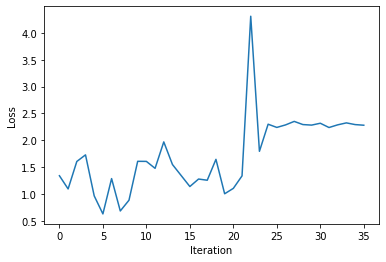

In [84]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# EXPERIMENT 2:
## Hyperparameters:
**Iteration: 20k**

**Batch Size: 200**

**Learning Rate: 0.0005**

**Number of Hidden Layers: 6 (ReLU->ReLU->ReLU->ReLU->ReLU->ReLU)**

**Dimension of Hidden Layers: 200**

**Optimizer: Adam**


In [85]:
batch_size = 200
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.0005

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

66


In [86]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:300
Test dataloader:50


In [87]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [88]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [90]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Iteration: 500. Loss: 0.5219957828521729. Accuracy: 83.66
Epoch:  3
Epoch:  4
Iteration: 1000. Loss: 0.4226800203323364. Accuracy: 85.52
Epoch:  5
Iteration: 1500. Loss: 0.2738294303417206. Accuracy: 87.23
Epoch:  6
Epoch:  7
Iteration: 2000. Loss: 0.33628520369529724. Accuracy: 87.76
Epoch:  8
Epoch:  9
Iteration: 2500. Loss: 0.3255946636199951. Accuracy: 87.99
Epoch:  10
Iteration: 3000. Loss: 0.2501943111419678. Accuracy: 88.22
Epoch:  11
Epoch:  12
Iteration: 3500. Loss: 0.2736193835735321. Accuracy: 88.28
Epoch:  13
Epoch:  14
Iteration: 4000. Loss: 0.23036649823188782. Accuracy: 88.19
Epoch:  15
Iteration: 4500. Loss: 0.25385144352912903. Accuracy: 88.34
Epoch:  16
Epoch:  17
Iteration: 5000. Loss: 0.21839822828769684. Accuracy: 88.74
Epoch:  18
Epoch:  19
Iteration: 5500. Loss: 0.20936749875545502. Accuracy: 88.74
Epoch:  20
Iteration: 6000. Loss: 0.2263176143169403. Accuracy: 88.34
Epoch:  21
Epoch:  22
Iteration: 6500. Loss: 0.18055018782615662. Accuracy: 8

[0.5219957828521729, 0.4226800203323364, 0.2738294303417206, 0.33628520369529724, 0.3255946636199951, 0.2501943111419678, 0.2736193835735321, 0.23036649823188782, 0.25385144352912903, 0.21839822828769684, 0.20936749875545502, 0.2263176143169403, 0.18055018782615662, 0.19598917663097382, 0.19943208992481232, 0.1244785338640213, 0.12192244827747345, 0.12752969563007355, 0.10731135308742523, 0.13078494369983673, 0.11849463731050491, 0.11513905227184296, 0.14574988186359406, 0.08394458144903183, 0.06804874539375305, 0.09812331199645996, 0.059401735663414, 0.09871909767389297, 0.0793379470705986, 0.052393533289432526, 0.059032078832387924, 0.09533486515283585, 0.05997316911816597, 0.08255179226398468, 0.11439807713031769, 0.04229000583291054, 0.06420422345399857, 0.05365027114748955, 0.040935009717941284]


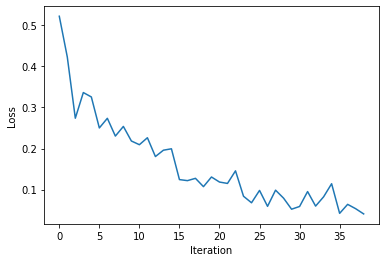

In [91]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()